Id start with some analysis, Inferences and strategies I came uo with from the data :
Not exactly 250K words → The dataset is smaller than initially expected.
All words are unique → No duplicates in the dataset.
Word length distribution:
Min-Max Length: 1 - 29 (Taking 32 for testing as a buffer).
Mean Length: 9.3
Median Length: 9
Bell-shaped distribution → Word lengths are normally distributed around 9.

Strategic Inferences for Hangman
1️⃣ Early Vowel Guessing
Vowels e, a, i are the most frequent → Prioritize them early in the game. [ Weighted Guessing ]
In words 5-20 letters long, vowel thresholding provides a solid information gain.
eg if less than 0.3 vowel ratio, guess a vowel first. if more than 0.6 guess a consonant. [ Weighted Guessing ]
2️⃣ Leveraging Disjoint Testing Set 🔥 Key Insight
Exploit the fact that the training & testing sets are disjoint.
Do not guess a word that appears in the training set.
If the best guess results in a word from the training set, pick the next best alternative.
3️⃣ Positional Letter Frequency for Smarter Guesses
Instead of guessing pure frequency-based letters, use a position-based strategy.
Construct a relative letter position heatmap per word length.[ +- 2 letters ]
Use cosine similarity to compare the heatmap with the training set.
If a position has a high certainty, prioritize confirming that letter.
4️⃣ High Information Gain Strategy
Since we have 6 tries, each wrong guess must maximize information gain.
Use entropy-based selection to pick the letter that eliminates the most possibilities.
[Never explored]
5️⃣ Suffix-Based Exploitation
Common suffixes provide high certainty for longer words:
-ing (11,703 words)
-ess, -ion, -ous, -ted, -ate
Combine with position-based probability for efficiency.


Rather than deciding what to use, it was imperative to first understand what to avoid.

1️⃣ Basic Frequency Analysis
Global letter frequency was generated.
While it serves as a good global fallback, it was not effective given the accuracy constraints.
2️⃣ Letter-Based Frequency Analysis
A strategy of Len(word) ± 2 was tested and provided closer results.
[INSIGHT] Cosine similarity between letter frequency distributions across similar-length words verified this.
Issue: Ignores context, so while useful as an add-on, it couldn’t be the default guesser.
3️⃣ N-Gram Analysis
A battle-tested method, but...
Unseen n-grams could result in zero probability, making it unreliable for words outside the training set.
4️⃣ Rule-Based Strategies
[INSIGHT] Vowel ratio was rarely above 0.6 of the total word length.
[INSIGHT] Hard-coding a check to avoid final guesses in the training dictionary saved a guess and potentially improved accuracy.
📌 Why I Avoided Bayesian & Probabilistic Methods
Bayesian methods & probabilistic models generally perform well on seen training data.
However, on a disjoint testing dataset, they could be detrimental.
Smoothing techniques could help, but due to time constraints, this approach was discarded.
📌 Reinforcement Learning (RL)
Tried a basic RL model, but...
Couldn’t get it to converge well to the data in a reasonable timeframe.
Potential: Given more time, an award-based RL structure may have provided the best results.
📌 Char-Based Masked Language Model (MLM)
Trained a masked language model (MLM), which was a gamble.
Challenges included:
Dataset creation → Masking parts of words to generate a proper train set. [ Final set was some 3+ GB]
Vectorizing & exploiting top 11 letters as a negative vector.
[INSIGHT] Why 11 letters? → "u" (the last vowel) was the 11th most frequent in the global letter hierarchy.
Actual training on an AMD GPU (not CUDA),  due to dataset size.
The most challenging yet the most fun approach!
Hopefully, the model converged, and regardless of the outcome, it was an incredible learning experience.

Huge thanks for this assignment! I learned a lot from it.
    
📌 Special Thanks!
🎉 Shoutout to my brother for lending his PC for training!
🔥 Would have fried my laptop (even with an RTX 4050) if I had tried training on it.

📌 Why Not LSTM?
I already understood LSTM well (built a smart electric grid forecaster using it).
A bi-LSTM may have converged better with lower compute, but...
Transformers were intriguing and provided a new learning opportunity.
Also, transformers offer:
Long-range dependencies
Better generalization on a disjoint test set (my biggest concern).
So, I went ahead with transformers instead of LSTMs—learning something new is always more exciting! 

count    227300.000000
mean          9.347761
std           2.981242
min           1.000000
25%           7.000000
50%           9.000000
75%          11.000000
max          29.000000
Name: length, dtype: float64


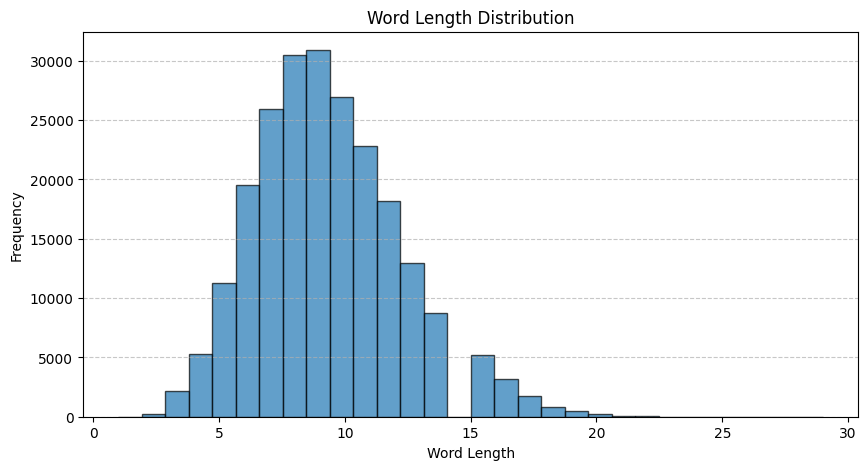

In [1]:
file_path = r"C:\Users\jaska\OneDrive\Desktop\Hangman Official\words_250000_train.txt"  
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataset

# Read words into a DataFrame
with open(file_path, "r") as f:
    words = [line.strip() for line in f.readlines()]

df = pd.DataFrame(words, columns=["word"])
df["length"] = df["word"].apply(len)

# Basic statistics
print(df["length"].describe())

# Plot histogram of word lengths
plt.figure(figsize=(10, 5))
plt.hist(df["length"], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.title("Word Length Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


   Letter  Frequency
4       e     233745
10      i     184746
0       a     179837
5       n     152259
13      o     150052
15      r     149228
1       s     148462
11      t     137277
8       l     122431
2       c      89367
9       u      77304
7       d      74856
14      p      65785
12      m      62191
3       h      58051
6       g      51850
22      y      40985
20      b      39840
19      f      26431
16      v      21057
17      k      18685
18      w      17732
24      z       8749
21      x       6050
25      q       3986
23      j       3790


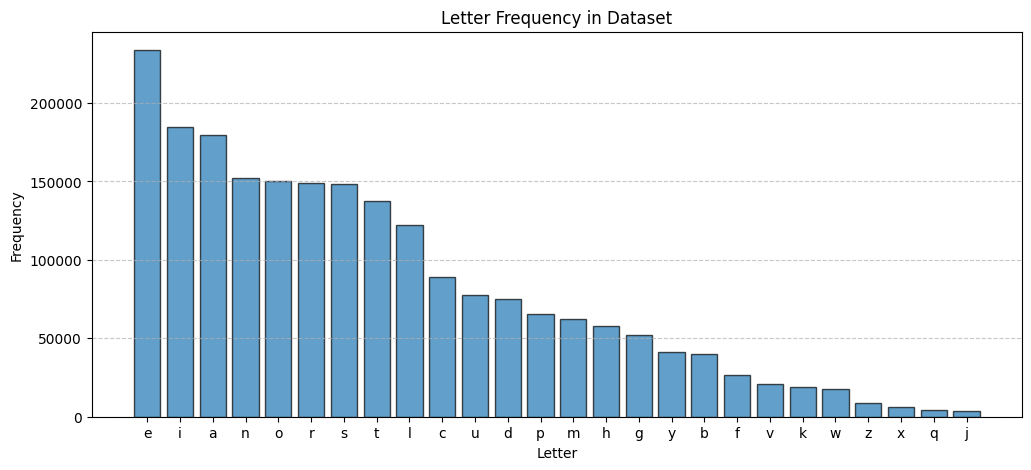

In [ ]:
from collections import Counter

# Count frequency of each letter in all words
letter_counts = Counter("".join(words))
letter_freq_df = pd.DataFrame(letter_counts.items(), columns=["Letter", "Frequency"])
letter_freq_df = letter_freq_df.sort_values(by="Frequency", ascending=False)

print(letter_freq_df)

# Plot letter frequencies
plt.figure(figsize=(12, 5))
plt.bar(letter_freq_df["Letter"], letter_freq_df["Frequency"], alpha=0.7, edgecolor='black')
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.title("Letter Frequency in Dataset")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
#use vowels aeio only

   Letter  Frequency
4       e     154827
10      i     134627
0       a     133659
15      r     120548
3       n     114976
13      o     111416
1       s     110214
11      t     108416
8       l      97083
2       c      75526
9       u      67623
7       d      65225
14      p      57125
12      m      55506
5       h      52006
6       g      46878
22      y      38705
20      b      36789
19      f      23530
16      v      20203
17      k      17594
18      w      16813
24      z       8273
21      x       6013
25      q       3903
23      j       3731


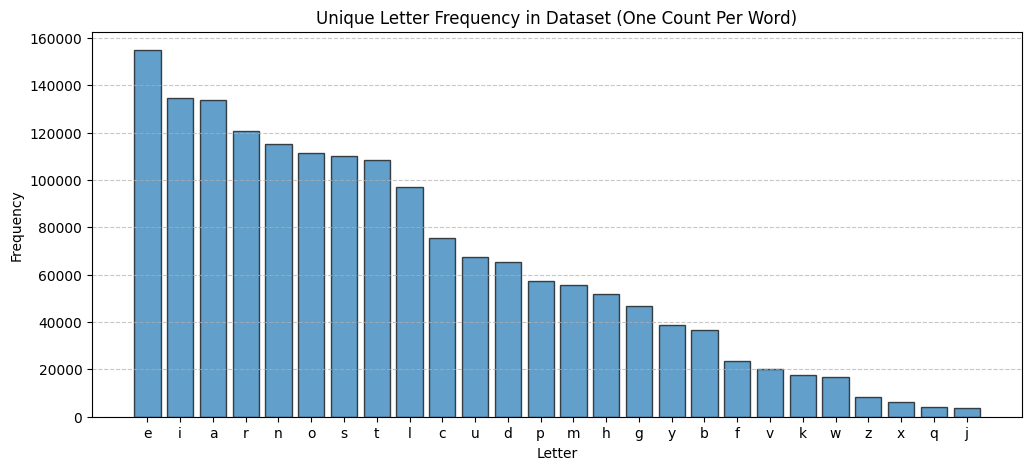

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'words' is your list of words
# Example: words = ["apple", "banana", "kiwi", "orange", "grape"]

# Count frequency of each letter in all words (unique letters per word)
global_letter_counts = Counter()

for word in words:
    unique_letters = set(word)  # Get unique letters in the word
    global_letter_counts.update(unique_letters)

letter_freq_df = pd.DataFrame(global_letter_counts.items(), columns=["Letter", "Frequency"])
letter_freq_df = letter_freq_df.sort_values(by="Frequency", ascending=False)

print(letter_freq_df)

# Plot letter frequencies
plt.figure(figsize=(12, 5))
plt.bar(letter_freq_df["Letter"], letter_freq_df["Frequency"], alpha=0.7, edgecolor='black')
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.title("Unique Letter Frequency in Dataset (One Count Per Word)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

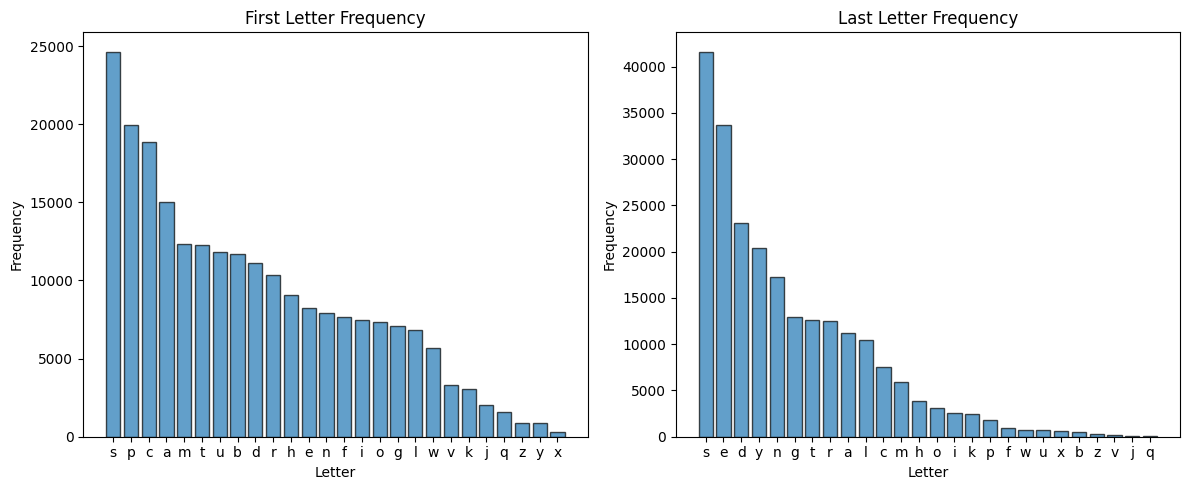

In [6]:
# First letter frequency
first_letter_counts = Counter([word[0] for word in words if word])
first_letter_df = pd.DataFrame(first_letter_counts.items(), columns=["Letter", "Frequency"])
first_letter_df = first_letter_df.sort_values(by="Frequency", ascending=False)

# print("First Letter Frequency:\n", first_letter_df)

# Last letter frequency
last_letter_counts = Counter([word[-1] for word in words if word])
last_letter_df = pd.DataFrame(last_letter_counts.items(), columns=["Letter", "Frequency"])
last_letter_df = last_letter_df.sort_values(by="Frequency", ascending=False)

# print("Last Letter Frequency:\n", last_letter_df)

# Plot first-letter and last-letter distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(first_letter_df["Letter"], first_letter_df["Frequency"], alpha=0.7, edgecolor='black')
axs[0].set_title("First Letter Frequency")
axs[0].set_xlabel("Letter")
axs[0].set_ylabel("Frequency")

axs[1].bar(last_letter_df["Letter"], last_letter_df["Frequency"], alpha=0.7, edgecolor='black')
axs[1].set_title("Last Letter Frequency")
axs[1].set_xlabel("Letter")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
#useless better use positional heatmaps

Top 10 Bigrams:
    Bigram  Count
90     er  39200
79     in  37762
82     ti  27596
49     on  27389
14     es  27128
53     te  26219
24     an  25117
42     re  24800
81     at  23611
12     al  23550
Top 10 Trigrams:
     Trigram  Count
216     ing  15154
205     ess   8423
93      ati   8072
104     ter   7912
95      ion   7691
160     nes   6804
155     ate   6552
177     ent   6454
94      tio   6191
399     ous   5647


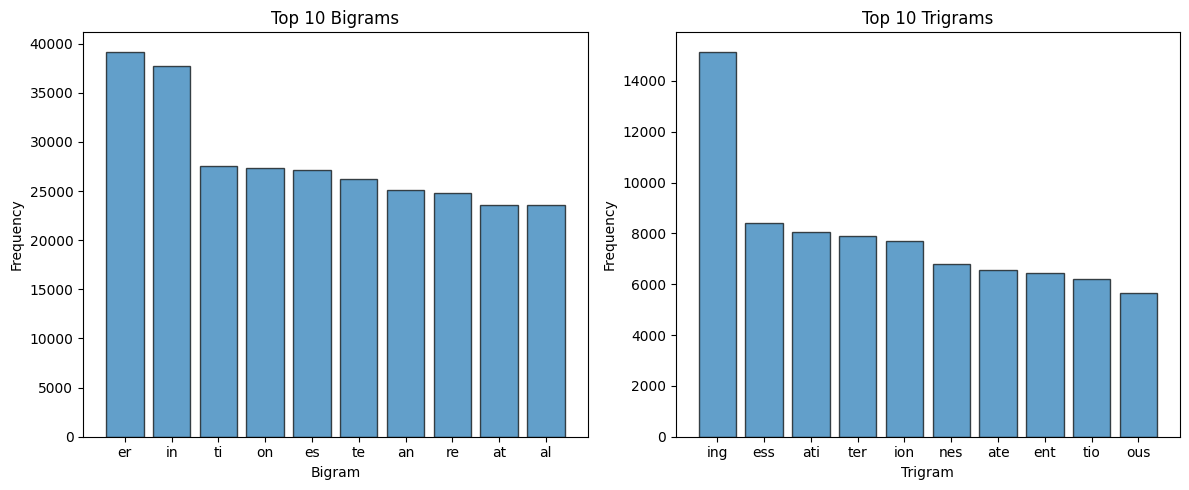

In [4]:
from itertools import islice

# Count letter bigrams and trigrams
bigrams = Counter()
trigrams = Counter()

for word in words:
    for i in range(len(word) - 1):
        bigrams[word[i:i+2]] += 1
    for i in range(len(word) - 2):
        trigrams[word[i:i+3]] += 1

# Convert to DataFrame
bigram_df = pd.DataFrame(bigrams.items(), columns=["Bigram", "Count"]).sort_values(by="Count", ascending=False)
trigram_df = pd.DataFrame(trigrams.items(), columns=["Trigram", "Count"]).sort_values(by="Count", ascending=False)

print("Top 10 Bigrams:\n", bigram_df.head(10))
print("Top 10 Trigrams:\n", trigram_df.head(10))

# Plot bigram & trigram frequencies
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(bigram_df["Bigram"][:10], bigram_df["Count"][:10], alpha=0.7, edgecolor='black')
axs[0].set_title("Top 10 Bigrams")
axs[0].set_xlabel("Bigram")
axs[0].set_ylabel("Frequency")

axs[1].bar(trigram_df["Trigram"][:10], trigram_df["Count"][:10], alpha=0.7, edgecolor='black')
axs[1].set_title("Top 10 Trigrams")
axs[1].set_xlabel("Trigram")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [5]:
# Find words with only one unique character (e.g., 'aaaaaa', 'zzzz')
unique_char_words = [word for word in words if len(set(word)) == 1]
print("Words with one unique character:\n", unique_char_words[:10])  # Show a sample

# Find extremely rare letters
rare_letters = letter_freq_df[letter_freq_df["Frequency"] < 500]  # Adjust threshold if needed
print("Rare Letters:\n", rare_letters)


Words with one unique character:
 ['aaa', 'aaaaaa', 'bb', 'bbb', 'c', 'cc', 'd', 'ddd', 'e', 'ee']
Rare Letters:
 Empty DataFrame
Columns: [Letter, Frequency]
Index: []


In [ ]:
import random
from collections import defaultdict, Counter

def get_best_guess_by_length(pattern, guessed_letters):
    """
    Heuristic: Choose the most frequent letter based on word length (±1).
    """
    pattern = pattern.replace(" ", "")  # Normalize pattern
    word_length = len(pattern)

    # Get letter frequencies for words of length (L-1, L, L+1)
    candidate_frequencies = defaultdict(int)
    for length in range(word_length - 1, word_length + 2):
        if length in word_length_frequencies:
            for letter, freq in word_length_frequencies[length].items():
                if letter not in guessed_letters:
                    candidate_frequencies[letter] += freq

    # If no candidates found, fallback to global frequency
    if not candidate_frequencies:
        candidate_frequencies = {k: v for k, v in LETTER_FREQUENCIES.items() if k not in guessed_letters}

    return max(candidate_frequencies, key=candidate_frequencies.get)


In [ ]:
def get_best_guess_by_bigrams_trigrams(pattern, guessed_letters):
    """
    Uses bigrams & trigrams to predict the most probable next letter.
    """
    pattern = pattern.replace(" ", "")  # Normalize pattern
    likely_guesses = Counter()
    remaining_letters = {l for l in global_letter_frequencies.keys() if l not in guessed_letters}

    # Scan pattern for known letters and suggest next based on common bigrams/trigrams
    for i in range(len(pattern) - 1):
        if pattern[i] != "_" and pattern[i + 1] == "_":  # Found a partially known bigram
            for bigram, _ in common_bigrams:
                if bigram[0] == pattern[i] and bigram[1] in remaining_letters:
                    likely_guesses[bigram[1]] += 1

    for i in range(len(pattern) - 2):
        if pattern[i] != "_" and pattern[i + 1] == "_" and pattern[i + 2] == "_":  # Found partial trigram
            for trigram, _ in common_trigrams:
                if trigram[0] == pattern[i] and trigram[1] in remaining_letters:
                    likely_guesses[trigram[1]] += 2  # Trigrams get more weight

    return max(likely_guesses, key=likely_guesses.get) if likely_guesses else None


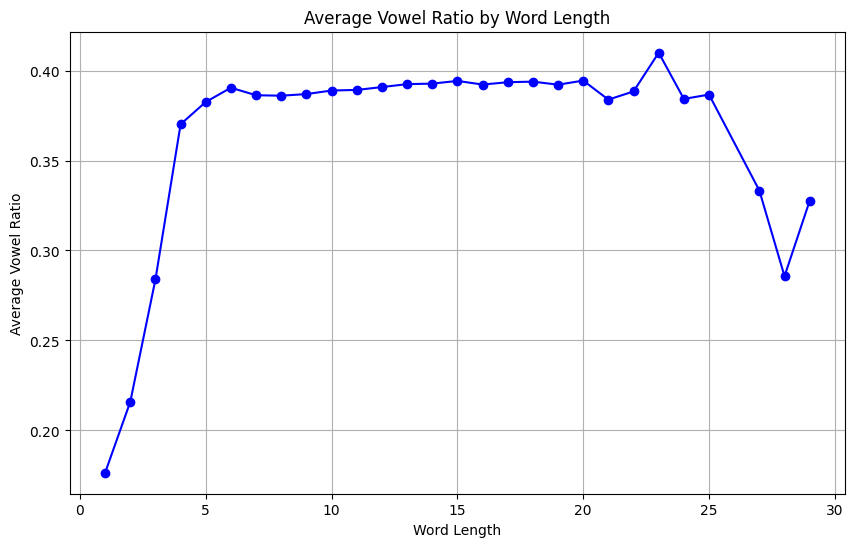

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict
import string

# Sample word list
word_list = df['word'].tolist()

# Function to calculate the vowel ratio of a word
def vowel_ratio(word):
    vowels = set('aeiou')
    word = word.lower().strip(string.punctuation)
    num_vowels = sum(1 for char in word if char in vowels)
    return num_vowels / len(word) if len(word) > 0 else 0

# Dictionary to store total vowel ratios and word counts by word length
vowel_ratios = defaultdict(lambda: [0, 0])

# Calculate vowel ratios for each word
for word in word_list:
    length = len(word)
    ratio = vowel_ratio(word)
    vowel_ratios[length][0] += ratio
    vowel_ratios[length][1] += 1

# Calculate average vowel ratios by word length
avg_vowel_ratios = {length: total / count for length, (total, count) in vowel_ratios.items()}

# Sort the data by word length
sorted_lengths = sorted(avg_vowel_ratios.keys())
sorted_ratios = [avg_vowel_ratios[length] for length in sorted_lengths]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(sorted_lengths, sorted_ratios, marker='o', linestyle='-', color='b')
plt.xlabel('Word Length')
plt.ylabel('Average Vowel Ratio')
plt.title('Average Vowel Ratio by Word Length')
plt.grid(True)
plt.show()


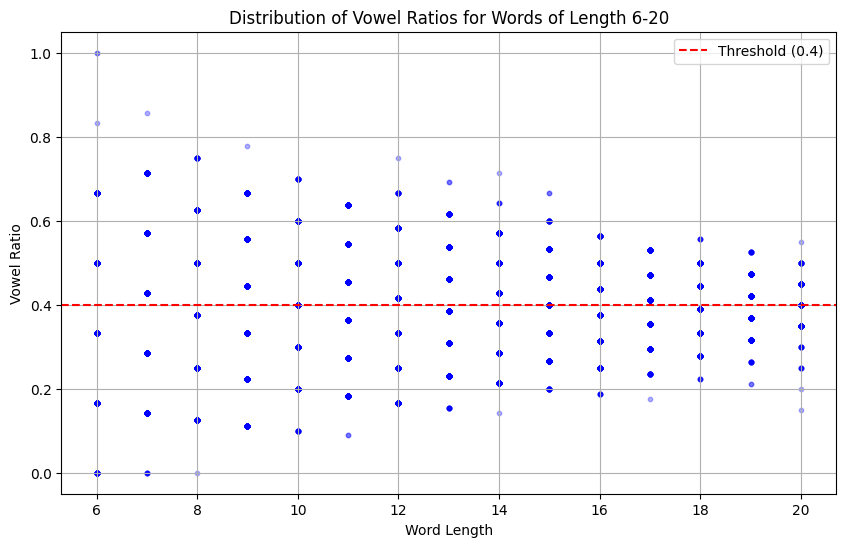

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Load the training word dataset
file_path = "words_250000_train.txt"  # Update this with the correct path
with open(file_path, "r") as f:
    words = [line.strip().lower() for line in f.readlines()]

# Function to calculate the vowel ratio of a word
def vowel_ratio(word):
    vowels = set("aeiou")
    num_vowels = sum(1 for char in word if char in vowels)
    return num_vowels / len(word) if len(word) > 0 else 0

# Store vowel ratios by word length
word_length_vowel_ratios = defaultdict(list)

for word in words:
    length = len(word)
    ratio = vowel_ratio(word)
    word_length_vowel_ratios[length].append(ratio)

# Filter data for words with lengths between 6 and 20
filtered_lengths = []
filtered_ratios = []

for length in range(6, 21):  # Consider word lengths from 6 to 20
    for ratio in word_length_vowel_ratios[length]:
        filtered_lengths.append(length)
        filtered_ratios.append(ratio)

# Scatter plot of vowel ratios for words of length 6-20
plt.figure(figsize=(10, 6))
plt.scatter(filtered_lengths, filtered_ratios, alpha=0.3, color='blue', s=10)
plt.axhline(y=0.4, color='red', linestyle='--', label="Threshold (0.4)")
plt.xlabel("Word Length")
plt.ylabel("Vowel Ratio")
plt.title("Distribution of Vowel Ratios for Words of Length 6-20")
plt.legend()
plt.grid(True)

# Display plot
plt.show()


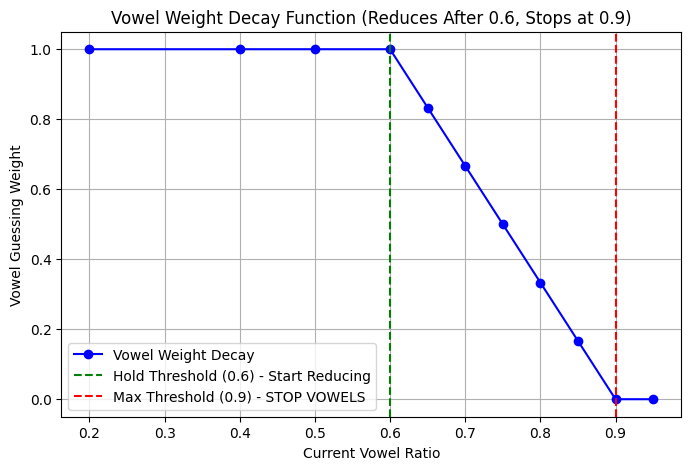

In [9]:
def vowel_weight(vowel_ratio, hold_threshold=0.6, max_threshold=0.9):
    """
    Compute the weight for vowels based on the current vowel ratio.
    - Full weight (1.0) for vowel ratio ≤ hold_threshold.
    - Linearly decrease weight after hold_threshold.
    - If vowel ratio exceeds max_threshold, weight is 0.
    """
    if vowel_ratio <= hold_threshold:
        return 1.0  # Full weight for vowels before 0.6
    elif vowel_ratio >= max_threshold:
        return 0.0  # Completely stop guessing vowels after 0.9
    else:
        return 1.0 - ((vowel_ratio - hold_threshold) / (max_threshold - hold_threshold))

# Test the function
test_ratios = [0.2, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
weights = [vowel_weight(r) for r in test_ratios]

# Plotting the function
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(test_ratios, weights, marker='o', linestyle='-', color='blue', label="Vowel Weight Decay")
plt.axvline(x=0.6, color='green', linestyle="--", label="Hold Threshold (0.6) - Start Reducing")
plt.axvline(x=0.9, color='red', linestyle="--", label="Max Threshold (0.9) - STOP VOWELS")
plt.xlabel("Current Vowel Ratio")
plt.ylabel("Vowel Guessing Weight")
plt.title("Vowel Weight Decay Function (Reduces After 0.6, Stops at 0.9)")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
def calculate_letter_frequency(word_list):
    all_letters = "".join(word_list)  # Concatenating all the words
    letter_counts = Counter(all_letters)  # Count frequency of each letter
    total_letters = sum(letter_counts.values())  # Calculate total number of letters
    
    # Calculate letter frequencies and sort them
    sorted_counts = letter_counts.most_common()
    letter_frequency = {k: v / total_letters for k, v in sorted_counts}
    return letter_frequency


In [20]:
def letter_frequency(word_list):
    """
    Given a list of words, compute the frequency distribution of letters.
    
    Returns:
        A dictionary where keys are letters and values are the relative frequency.
    """
    total_counts = collections.Counter()
    total_letters = 0
    for word in word_list:
        total_counts.update(word)
        total_letters += len(word)
    # Calculate relative frequency for each letter.
    return {letter: count / total_letters for letter, count in total_counts.items()}

# Compute frequency distribution for each word-length group.
dist_by_length = {}
for length, group in words_by_length.items():
    dist_by_length[length] = letter_frequency(group)


In [21]:
import numpy as np

def cosine_similarity(dist1, dist2):
    """
    Compute the cosine similarity between two frequency distributions.
    
    dist1, dist2: dictionaries mapping letters to frequencies.
    
    Returns:
        Cosine similarity value.
    """
    # Create a set of all letters present in either distribution.
    all_letters = set(dist1.keys()).union(dist2.keys())
    # Create frequency vectors.
    vec1 = np.array([dist1.get(letter, 0) for letter in all_letters])
    vec2 = np.array([dist2.get(letter, 0) for letter in all_letters])
    # Avoid division by zero.
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# For each word length, compare its distribution with groups that are ±2 lengths away.
similarities = {}
for length in sorted(dist_by_length.keys()):
    similarities[length] = {}
    for diff in range(-2, 3):  # This will check for length-2, length-1, length, length+1, length+2
        compare_length = length + diff
        if compare_length in dist_by_length:
            sim = cosine_similarity(dist_by_length[length], dist_by_length[compare_length])
            similarities[length][compare_length] = sim
    print(f"Length {length} similarities:", similarities[length])


Length 1 similarities: {1: np.float64(1.0), 2: np.float64(0.8183330322011184), 3: np.float64(0.7544232802426897)}
Length 2 similarities: {1: np.float64(0.8183330322011185), 2: np.float64(1.0000000000000002), 3: np.float64(0.9185515162666584), 4: np.float64(0.8667809647125607)}
Length 3 similarities: {1: np.float64(0.7544232802426897), 2: np.float64(0.9185515162666584), 3: np.float64(1.0), 4: np.float64(0.963762919079464), 5: np.float64(0.9419958120451123)}
Length 4 similarities: {2: np.float64(0.8667809647125605), 3: np.float64(0.963762919079464), 4: np.float64(1.0000000000000002), 5: np.float64(0.995294879002407), 6: np.float64(0.98859062268442)}
Length 5 similarities: {3: np.float64(0.9419958120451123), 4: np.float64(0.995294879002407), 5: np.float64(0.9999999999999999), 6: np.float64(0.9950605244581393), 7: np.float64(0.9909022305014251)}
Length 6 similarities: {4: np.float64(0.9885906226844201), 5: np.float64(0.9950605244581393), 6: np.float64(1.0000000000000002), 7: np.float64(0.9

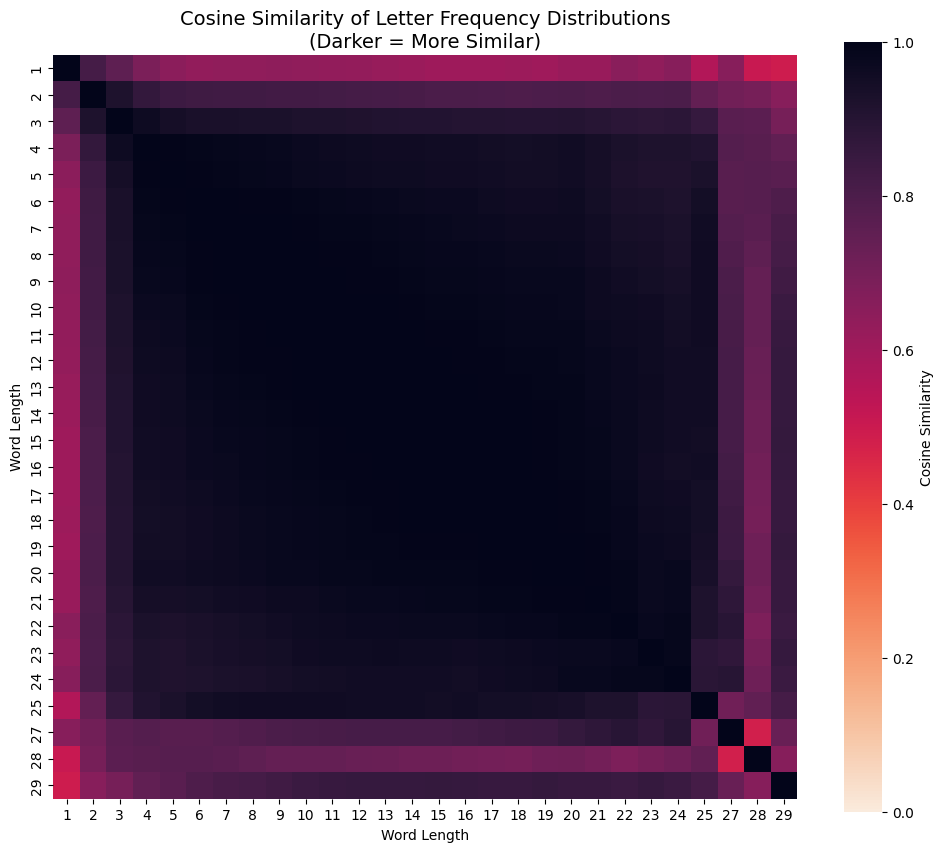

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose 'similarity_matrix' is already computed and
# 'lengths' is your sorted list of word lengths.

plt.figure(figsize=(12, 10))  # Make the figure larger

# Option 1: Continuous colormap with many steps
# We use "rocket_r" which is the reversed version of Seaborn's "rocket" palette
sns.heatmap(
    similarity_matrix,
    cmap='rocket_r',       # reversed colormap so higher = darker
    xticklabels=lengths,
    yticklabels=lengths,
    square=True,
    cbar_kws={'label': 'Cosine Similarity'},
    vmin=0,                # Minimum similarity = 0
    vmax=1,                # Maximum similarity = 1
    annot=False            # Set True if you want numeric values in cells
)
plt.title('Cosine Similarity of Letter Frequency Distributions\n(Darker = More Similar)', fontsize=14)
plt.xlabel('Word Length')
plt.ylabel('Word Length')
plt.show()


In [ ]:
###########
Final Model

In [1]:
# Step 1: Basic Imports
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Import torch-directml
import torch_directml

# Set device to AMD GPU via DirectML
device = torch_directml.device()

# Quick check
print("Using device:", device)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\pahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\pahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\traitlets\config\application.py", line 1075, in launch

Using device: privateuseone:0


In [ ]:
# Step 2: Toy word list 
# word_list = [
#     "MAGNETIC", "COMPUTER", "BASKETBALL", "PYTHON", "ASTRONOMY",
#     "QUESTION", "QUIZZICAL", "RHYTHM", "UNIQUE", "STRENGTH"
# ]

# In practice:
with open(r'C:\Users\pahul\OneDrive\Desktop\Hangman\Hangman-PPO-LSTM-main\cleaned_word_list.txt', 'r') as f:
    word_list = [line.strip().upper() for line in f if line.strip()]
word_list = list(set(word_list))  # optional dedup
print(len(word_list))


226836


In [3]:
# Step 3: Character Vocab Setup
TOP_11_LETTERS = ["E", "I", "A", "R", "N", "O", "S", "T", "L", "C", "U"]
ALL_LETTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
PAD_TOKEN = "<PAD>"
MASK_TOKEN = "<MASK>"
MAX_LENGTH = 32
# Create a list of tokens in our vocabulary.
# We'll do: [PAD_TOKEN, MASK_TOKEN] + all letters
vocab_tokens = [PAD_TOKEN, MASK_TOKEN] + list(ALL_LETTERS)
vocab_size = len(vocab_tokens)  # Should be 28 if only A–Z plus 2 specials

# Map token -> index and index -> token
token_to_idx = {token: idx for idx, token in enumerate(vocab_tokens)}
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

print("Vocab Size:", vocab_size)
print("Example mapping:", token_to_idx)


Vocab Size: 28
Example mapping: {'<PAD>': 0, '<MASK>': 1, 'A': 2, 'B': 3, 'C': 4, 'D': 5, 'E': 6, 'F': 7, 'G': 8, 'H': 9, 'I': 10, 'J': 11, 'K': 12, 'L': 13, 'M': 14, 'N': 15, 'O': 16, 'P': 17, 'Q': 18, 'R': 19, 'S': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27}


In [4]:
# Step 4: Tokenization Helpers

  # maximum length of words in your dataset (you mentioned 32)

def word_to_tokens(word, max_length=MAX_LENGTH):
    """
    Convert a word (string) into a list of token IDs, 
    padded up to max_length with <PAD>.
    """
    tokens = []
    for ch in word:
        if ch in token_to_idx:
            tokens.append(token_to_idx[ch])
        else:
            # If there's an unexpected char, skip or handle differently
            pass
    
    # Pad if shorter than max_length
    if len(tokens) < max_length:
        tokens += [token_to_idx[PAD_TOKEN]] * (max_length - len(tokens))
    else:
        tokens = tokens[:max_length]  # truncate if longer
    
    return tokens

def tokens_to_word(token_ids):
    """
    Convert a list of token IDs back into a string (ignoring PAD and MASK).
    """
    chars = []
    for idx in token_ids:
        token = idx_to_token[idx]
        if token not in [PAD_TOKEN, MASK_TOKEN]:
            chars.append(token)
    return "".join(chars)


In [5]:
# Step 5: Create Masked Datasets
TOP_11_LETTERS = ["E", "I", "A", "R", "N", "O", "S", "T", "L", "C", "U"]
def create_masked_samples_with_neg_top11(
    word, 
    min_revealed=1, 
    max_revealed=None, 
    num_copies=5, 
    max_length=32
):
    """
    Generate multiple partial states from 'word' with varying numbers
    of revealed letters (between min_revealed and max_revealed).
    
    Also picks a random subset of the top-11 letters that are NOT in 'word'
    to simulate 'absent letters.' Returns a list of (input_tokens, target_tokens, neg_info_11d).

    :param word: The secret word (string).
    :param min_revealed: The minimum number of letters to reveal.
    :param max_revealed: The maximum number of letters to reveal. If None,
                         defaults to word_length - 1 (ensuring at least 1 is masked
                         if the word length > 1).
    :param num_copies: How many partial-state samples to generate for this word.
    :param max_length: Maximum length for padding/truncation.
    :return: A list of (input_tokens, target_tokens, neg_info_11d) tuples.
             - input_tokens: a list of length max_length (tokens for the partial reveal).
             - target_tokens: a list of length max_length (tokens for masked positions).
             - neg_info_11d: a length-11 binary vector for "absent letters" among the top 11.
    """
    word = word.upper()
    token_ids = word_to_tokens(word, max_length)
    actual_len = min(len(word), max_length)
    
    # Letters in the word
    letters_in_word = set(word)
    
    # Potential absent letters (top-11 only) are those in TOP_11_LETTERS but not in word
    letters_not_in_word_top11 = set(TOP_11_LETTERS) - letters_in_word
    
    # If user didn't specify max_revealed, ensure at least 1 char remains masked if len>1
    if max_revealed is None:
        max_revealed = max(actual_len - 1, 1)
    
    samples = []
    
    for _ in range(num_copies):
        # 1) Randomly pick how many letters to reveal (between min_revealed & max_revealed)
        n_reveal = random.randint(min_revealed, max_revealed)
        n_reveal = min(n_reveal, actual_len)  # clamp to actual_len if needed
        
        # Choose which positions to reveal
        reveal_positions = set(random.sample(list(range(actual_len)), n_reveal))
        
        # 2) Build input_tokens & target_tokens
        input_tokens = token_ids.copy()
        target_tokens = [token_to_idx[PAD_TOKEN]] * max_length
        
        for i in range(actual_len):
            if i in reveal_positions:
                # Keep letter unmasked in input
                # => target_tokens[i] = <PAD> so no loss on unmasked positions
                target_tokens[i] = token_to_idx[PAD_TOKEN]
            else:
                # Mask it
                original_t = input_tokens[i]
                input_tokens[i] = token_to_idx[MASK_TOKEN]
                target_tokens[i] = original_t
        
        # 3) Decide how many absent letters to claim, from letters_not_in_word_top11
        possible_absent_count = len(letters_not_in_word_top11)
        if possible_absent_count > 0:
            # For example, randomly pick up to 4 absent letters
            n_absent = random.randint(0, min(4, possible_absent_count))
            chosen_absent = set(random.sample(list(letters_not_in_word_top11), n_absent))
        else:
            chosen_absent = set()
        
        # 4) Build the 11-d negative info vector
        #    1 if letter is absent, else 0
        neg_info_11d = [1 if ch in chosen_absent else 0 for ch in TOP_11_LETTERS]
        
        # Each sample: (input_tokens, target_tokens, neg_info_11d)
        samples.append((input_tokens, target_tokens, neg_info_11d))
    
    return samples

def build_dataset_with_neg_top11(
    words,
    min_revealed=1,
    max_revealed=None,
    copies_per_word=100,
    max_length=32
):
    dataset = []
    for w in words:
        # For each word, create partial states
        samples = create_masked_samples_with_neg_top11(
            w,
            min_revealed=min_revealed,
            max_revealed=max_revealed,
            num_copies=copies_per_word,
            max_length=max_length
        )
        # Extend our global dataset
        dataset.extend(samples)
    return dataset

# Let's create a small dataset from our toy word list
# train_data = build_dataset_with_neg_top11(word_list, mask_prob=0.2, copies_per_word=5)
# print("Number of training samples:", len(train_data))


In [6]:
import pickle
def save_dataset(dataset, filename):
    with open(filename, "wb") as f:
        pickle.dump(dataset, f)
    print(f"Saved dataset to {filename}")

def load_dataset(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data
import os
def save_dataset_in_chunks(dataset, base_filename, chunk_size=460000000):  #make this sort of half of dataset
    """ Save dataset into multiple smaller files to avoid RAM overload. """
    os.makedirs(os.path.dirname(base_filename), exist_ok=True)
    
    num_chunks = (len(dataset) // chunk_size) + 1
    for i in range(num_chunks):
        chunk = dataset[i * chunk_size: (i + 1) * chunk_size]
        if chunk:
            filename = f"{base_filename}_chunk_{i}.pkl"
            with open(filename, "wb") as f:
                pickle.dump(chunk, f)
            print(f"Saved {len(chunk)} samples to {filename}")

def load_dataset_in_chunks(base_filename, max_chunks=None):
    """ Dynamically load dataset in chunks to avoid MemoryError. """
    dataset = []
    chunk_id = 0

    while True:
        filename = f"{base_filename}_chunk_{chunk_id}.pkl"
        if not os.path.exists(filename):
            break  # No more chunks
        print(f"Loading chunk: {filename}")
        
        with open(filename, "rb") as f:
            chunk = pickle.load(f)
            dataset.extend(chunk)
        
        chunk_id += 1
        if max_chunks and chunk_id >= max_chunks:
            break  # Stop after loading max_chunks if needed

    return dataset
# train_data = load_dataset("train_dataset.pkl")
# val_data = load_dataset("val_dataset.pkl")
# print("Train samples:", len(train_data), "Val samples:", len(val_data))

In [7]:
# Suppose you load your big dictionary from a file
# with open("my_dictionary.txt","r") as f:
#     word_list = [line.strip() for line in f if line.strip()]
# word_list = ["MAGNETIC", "COMPUTER", "PYTHON", "BASKETBALL", "QUESTION"]  # example

# Shuffle & maybe split into train/val


######dont run every time##########################

random.shuffle(word_list)
split_idx = int(len(word_list)*0.9)
train_words = word_list[:split_idx]
val_words   = word_list[split_idx:]

# Build dataset
train_data = build_dataset_with_neg_top11(
    train_words,
    min_revealed=1,
    max_revealed=None,
    copies_per_word=100
)
val_data = build_dataset_with_neg_top11(
    val_words,
    min_revealed=1,
    max_revealed=None,
    copies_per_word=100
)

# Save to file
save_dataset_in_chunks(train_data, r"D:\Hangman Dataset\train_new")
save_dataset_in_chunks(val_data, r"D:\Hangman Dataset\val_new")


Saved 20415200 samples to D:\Hangman Dataset\train_new_chunk_0.pkl
Saved 2268400 samples to D:\Hangman Dataset\val_new_chunk_0.pkl


In [8]:
# Step 6: PyTorch Dataset & DataLoader

from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset

class MaskedLmWithNegDataset(Dataset):
    def __init__(self, samples):
        """
        samples: list of (input_tokens, target_tokens, neg_info_vec)
        """
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        inp, tgt, neg_info = self.samples[idx]
        inp_tensor = torch.tensor(inp, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt, dtype=torch.long)
        neg_tensor = torch.tensor(neg_info, dtype=torch.float)  # 26-d float/binary
        return inp_tensor, tgt_tensor, neg_tensor





In [9]:
batch_size = 128
train_dataset = MaskedLmWithNegDataset(train_data)
val_dataset = MaskedLmWithNegDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# Step 7: Define the Model

class MiniTransformerMLMTop11(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, max_len=32, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_len, d_model)
        
        # Only 11 letters for "negative constraints" embedding
        self.neg_embed = nn.Linear(11, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=256, 
            dropout=dropout, 
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(d_model, vocab_size)
    
    def forward(self, input_ids, neg_info_11d):
        """
        input_ids: (batch, seq_len) token IDs
        neg_info_11d: (batch, 11) binary vector
        """
        batch_size, seq_len = input_ids.shape
        
        # Normal token+pos embeddings
        tok_emb = self.token_embed(input_ids)   # (batch, seq_len, d_model)
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        pos_emb = self.pos_embed(positions)     # (1, seq_len, d_model)
        
        x = tok_emb + pos_emb  # shape (batch, seq_len, d_model)
        
        # Project the 11-d vector to d_model
        neg_vec = self.neg_embed(neg_info_11d)  # (batch, d_model)
        # Expand across the sequence
        neg_vec = neg_vec.unsqueeze(1).expand(-1, seq_len, -1)
        
        x = x + neg_vec
        
        # Transformer
        x = self.transformer_encoder(x)  # (batch, seq_len, d_model)
        
        # Final classification
        logits = self.fc_out(x)  # (batch, seq_len, vocab_size)
        return logits



# Instantiate the model
# model = MiniTransformerMLMTop11(
#     vocab_size=vocab_size, 
#     d_model=128, 
#     nhead=4, 
#     num_layers=2, 
#     max_len=MAX_LENGTH,
#     dropout=0.1      # 0.1 dropout
# ).to(device)


# print("Model initialized on device:", device)


In [11]:
import os
def train_model_chunked_epochs(
    model,
    train_base_path,      # e.g., "D:\\Hangman Dataset\\train"
    val_loader,
    device,
    vocab_size,
    pad_idx,
    max_epochs=20,
    lr=1e-3,
    weight_decay=1e-5,
    batch_size=128,
    save_interval=1,
    save_dir=r"D:\Hangman Dataset\model_checkpoints"
):
    import os
    import pickle
    from torch.utils.data import DataLoader
    
    os.makedirs(save_dir, exist_ok=True)
    
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 1) Determine total number of chunks
    chunk_id = 0
    while os.path.exists(f"{train_base_path}_chunk_{chunk_id}.pkl"):
        chunk_id += 1
    total_chunks = chunk_id
    print(f"Found {total_chunks} training chunks at {train_base_path}_chunk_*.pkl")

    best_val_loss = float("inf")
    
    for epoch in range(max_epochs):
        print(f"\n===== EPOCH {epoch+1}/{max_epochs} =====")
        model.train()
        total_train_loss = 0.0
        total_samples = 0
        
        # 2) Loop over all chunks for this epoch
        for chunk_i in range(total_chunks):
            chunk_filename = f"{train_base_path}_chunk_{chunk_i}.pkl"
            print(f"\nLoading chunk {chunk_i} from {chunk_filename} ...")
            
            # Load chunk i
            with open(chunk_filename, "rb") as f:
                chunk_data = pickle.load(f)
            
            # Create dataset/dataloader for this chunk
            chunk_dataset = MaskedLmWithNegDataset(chunk_data)
            chunk_loader = DataLoader(
                chunk_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=4,
                pin_memory=True
            )
            
            # 3) Train on this chunk
            for inp, tgt, neg_info in chunk_loader:
                inp, tgt, neg_info = inp.to(device), tgt.to(device), neg_info.to(device)
                optimizer.zero_grad()
                
                logits = model(inp, neg_info)  # forward
                b, s, v = logits.shape
                logits_2d = logits.view(-1, v)
                tgt_2d = tgt.view(-1)
                
                loss = criterion(logits_2d, tgt_2d)
                loss.backward()
                optimizer.step()
                
                total_train_loss += loss.item()
                total_samples += b
        
        # 4) After finishing ALL chunks, compute average train loss
        avg_train_loss = total_train_loss / total_samples
        print(f"\nCompleted EPOCH {epoch+1}/{max_epochs} | Train Loss: {avg_train_loss:.4f}")
        
        # 5) Validation
        model.eval()
        total_val_loss = 0.0
        val_samples = 0
        with torch.no_grad():
            for inp, tgt, neg_info in val_loader:
                inp, tgt, neg_info = inp.to(device), tgt.to(device), neg_info.to(device)
                logits = model(inp, neg_info)
                
                b, s, v = logits.shape
                logits_2d = logits.view(-1, v)
                tgt_2d = tgt.view(-1)
                
                loss = criterion(logits_2d, tgt_2d)
                total_val_loss += loss.item()
                val_samples += b
        
        avg_val_loss = total_val_loss / val_samples if val_samples > 0 else 0
        print(f"Val Loss: {avg_val_loss:.4f}")
        
        # 6) Save checkpoint every 'save_interval' epochs
        if (epoch + 1) % save_interval == 0:
            ckpt_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pt")
            torch.save(model.state_dict(), ckpt_path)
            print(f"Saved checkpoint: {ckpt_path}")
        
        # 7) Track best val loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_ckpt = os.path.join(save_dir, "model_best.pt")
            torch.save(model.state_dict(), best_ckpt)
            print(f"Best val so far ({avg_val_loss:.4f}). Model saved to {best_ckpt}")



In [9]:
# Step 9: Single Inference Example

def predict_next_letter(partial_word_pattern):
    """
    partial_word_pattern: list of length <= MAX_LENGTH, e.g. ['_', 'A', '_', 'E', '_'] 
    We'll replace '_' with <MASK>.
    Then run it through the model and combine probabilities.
    Returns: a dictionary of letter -> total probability across mask positions.
    """
    # 1) Build input token IDs
    token_ids = []
    for ch in partial_word_pattern:
        if ch == '_':
            token_ids.append(token_to_idx[MASK_TOKEN])
        else:
            token_ids.append(token_to_idx[ch])
    
    # Pad/truncate to MAX_LENGTH
    if len(token_ids) < MAX_LENGTH:
        token_ids += [token_to_idx[PAD_TOKEN]] * (MAX_LENGTH - len(token_ids))
    else:
        token_ids = token_ids[:MAX_LENGTH]
    
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)  # shape (1, seq_len)
    
    # 2) Forward pass
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)  # shape (1, seq_len, vocab_size)
    
    # 3) Identify which positions are masked
    mask_positions = [i for i, t in enumerate(token_ids) if t == token_to_idx[MASK_TOKEN]]
    
    # 4) Gather probabilities for each masked position
    letter_probs = {letter: 0.0 for letter in ALL_LETTERS}
    
    for pos in mask_positions:
        # logits[0, pos] is shape (vocab_size,) for the single batch
        # Convert to probabilities (softmax)
        prob = torch.softmax(logits[0, pos], dim=-1)
        # Add these probabilities to our letter_probs
        for i in range(len(vocab_tokens)):
            # skip if it's PAD or MASK
            if i >= 2:  # 0=PAD, 1=MASK, 2..27= A..Z
                letter_index = i - 2  # map i-> index in ALL_LETTERS
                letter_probs[ALL_LETTERS[letter_index]] += prob[i].item()
    
    # 5) We can pick the letter with the highest total probability
    sorted_letters = sorted(letter_probs.items(), key=lambda x: x[1], reverse=True)
    return sorted_letters

# Let's test with a partial pattern
test_pattern = ['_', 'A', '_', 'E', '_']  # e.g. length 5
results = predict_next_letter(test_pattern)
print("Predictions (letter -> combined probability):")
for letter, score in results[:10]:
    print(f"{letter}: {score:.4f}")


Predictions (letter -> combined probability):
T: 0.6582
U: 0.5896
R: 0.3556
E: 0.2874
C: 0.1802
N: 0.1638
I: 0.0950
B: 0.0920
G: 0.0757
Q: 0.0717


In [ ]:
import os
import random
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# If AMD GPU with DirectML
import torch_directml
device = torch_directml.device()
print("Using device:", device)

###############################################################################
# 1) VOCAB & CONSTANTS
###############################################################################
TOP_11_LETTERS = ["E", "I", "A", "R", "N", "O", "S", "T", "L", "C", "U"]
ALL_LETTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

PAD_TOKEN = "<PAD>"
MASK_TOKEN = "<MASK>"
UNK_TOKEN = "<UNK>"

token_to_idx = {
    PAD_TOKEN: 0,
    MASK_TOKEN: 1
}
start_idx = 2
for ch in ALL_LETTERS:
    token_to_idx[ch] = start_idx
    start_idx += 1

PAD_IDX = token_to_idx[PAD_TOKEN]  # e.g. 0
MAX_LENGTH = 32

###############################################################################
# 2) DATASET CLASS
###############################################################################
class MaskedLmWithNegDataset(Dataset):
    def __init__(self, samples):
        # samples is a list of (inp, tgt, neg_info_11d)
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        inp, tgt, neg_info = self.samples[idx]
        inp_tensor = torch.tensor(inp, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt, dtype=torch.long)
        neg_tensor = torch.tensor(neg_info, dtype=torch.float)
        return inp_tensor, tgt_tensor, neg_tensor

###############################################################################
# 3) MODEL DEFINITION
###############################################################################
class MiniTransformerMLMTop11(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, max_len=32, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_len, d_model)
        
        # negative constraints embedding (11 letters)
        self.neg_embed = nn.Linear(11, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=256, 
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(d_model, vocab_size)
    
    def forward(self, inp, neg_info):
        """
        inp: (batch, seq_len)
        neg_info: (batch, 11)
        """
        batch_size, seq_len = inp.shape
        
        tok_emb = self.token_embed(inp)  # (batch, seq_len, d_model)
        positions = torch.arange(seq_len, device=inp.device).unsqueeze(0)
        pos_emb = self.pos_embed(positions)  # (1, seq_len, d_model)
        
        x = tok_emb + pos_emb
        
        # incorporate negative vector
        neg_vec = self.neg_embed(neg_info)   # (batch, d_model)
        neg_vec = neg_vec.unsqueeze(1).expand(-1, seq_len, -1)
        
        x = x + neg_vec
        
        x = self.transformer(x)  # (batch, seq_len, d_model)
        logits = self.fc_out(x)  # (batch, seq_len, vocab_size)
        return logits

###############################################################################
# 4) TRAINING FUNCTION (NO CHUNKING)
###############################################################################
def train_model_nofrills(
    model,
    train_loader,
    val_loader,
    device,
    vocab_size,
    pad_idx,
    max_epochs=5,
    lr=1e-3,
    weight_decay=1e-5,
    save_interval=1,
    save_dir=r"D:\Hangman Dataset\model_checkpoints"
):
    import os
    os.makedirs(save_dir, exist_ok=True)

    # ✅ Optimized AdamW optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ✅ Standard loss function (ignores PAD_IDX)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    best_val_loss = float("inf")

    for epoch in range(max_epochs):
        print(f"\n===== EPOCH {epoch+1}/{max_epochs} =====")
        model.train()

        total_train_loss = 0.0
        total_train_samples = 0

        for i, (inp, tgt, neg_info) in enumerate(train_loader):
            inp, tgt, neg_info = inp.to(device), tgt.to(device), neg_info.to(device)

            optimizer.zero_grad()

            # 🚀 Standard FP32 precision (since AMP is not supported on DirectML)
            logits = model(inp, neg_info)
            b, s, v = logits.shape
            logits_2d = logits.view(-1, v)
            tgt_2d = tgt.view(-1)
            loss = criterion(logits_2d, tgt_2d)

            loss.backward()  # 🚀 Standard FP32 backpropagation
            optimizer.step()

            total_train_loss += loss.item()
            total_train_samples += b
        
        avg_train_loss = total_train_loss / total_train_samples if total_train_samples else 0
        print(f"✅ Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")

        # VALIDATION PHASE
        model.eval()
        total_val_loss = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for inp, tgt, neg_info in val_loader:
                inp, tgt, neg_info = inp.to(device), tgt.to(device), neg_info.to(device)
                logits = model(inp, neg_info)

                b, s, v = logits.shape
                logits_2d = logits.view(-1, v)
                tgt_2d = tgt.view(-1)

                val_loss = criterion(logits_2d, tgt_2d)
                total_val_loss += val_loss.item()
                total_val_samples += b
        
        avg_val_loss = total_val_loss / total_val_samples if total_val_samples else 0
        print(f"✅ Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f}")

        # SAVE CHECKPOINTS
        if (epoch + 1) % save_interval == 0:
            ckpt_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pt")
            torch.save(model.state_dict(), ckpt_path)
            print(f"💾 Saved checkpoint: {ckpt_path}")

        # TRACK BEST VALIDATION LOSS
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_ckpt = os.path.join(save_dir, "model_best.pt")
            torch.save(model.state_dict(), best_ckpt)
            print(f"🏆 New best validation loss: {avg_val_loss:.4f} - Model saved to {best_ckpt}")


###############################################################################
# 5) MAIN
###############################################################################
def main():
    # A) Load full train & val from single .pkl files
    train_pkl = r"D:\Hangman Dataset\train_dataset.pkl"
    val_pkl   = r"D:\Hangman Dataset\val_dataset.pkl"
    
    print(f"Loading train dataset from {train_pkl} ...")
    with open(train_pkl, "rb") as f:
        train_data = pickle.load(f)
    print(f"Train samples: {len(train_data)}")
    
    print(f"Loading val dataset from {val_pkl} ...")
    with open(val_pkl, "rb") as f:
        val_data = pickle.load(f)
    print(f"Val samples: {len(val_data)}")
    
    # B) Create Dataset + DataLoader
    train_dataset = MaskedLmWithNegDataset(train_data)
    val_dataset   = MaskedLmWithNegDataset(val_data)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
    
    # C) Create Model
    model = MiniTransformerMLMTop11(
        vocab_size=len(token_to_idx),
        d_model=128,
        nhead=4,
        num_layers=2,
        max_len=MAX_LENGTH,
        dropout=0.1
    ).to(device)
    
    # D) Train
    train_model_nofrills(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        vocab_size=len(token_to_idx),
        pad_idx=PAD_IDX,
        max_epochs=5,
        lr=1e-3,
        weight_decay=1e-5,
        save_interval=1,
        save_dir=r"D:\Hangman Dataset\model_checkpoints"
    )

if __name__ == "__main__":
    main()


For the first 2 guesses, letter preq. based model was used.

In [ ]:
from collections import defaultdict, Counter

class ConfidenceBasedHangmanSolver:
    def __init__(self, training_dict):
       
        self.length_freq = defaultdict(Counter)
        self.global_freq = Counter()
        self.vowel_set = {'a', 'e', 'i', 'o', 'u'}
        
        # Preprocess with smoothing
        for word in training_dict:
            word = word.strip().lower()
            padded = f'^{word}$'
            
                    
            # Length frequencies
            self.length_freq[len(word)].update(word)
            self.global_freq.update(word)
            
        # Convert counts to probabilities
                        
        self.global_order = sorted(
            self.global_freq.keys(),
            key=lambda x: (-self.global_freq[x], x)
        )
        self.reset_game()

    def reset_game(self):
        self.guessed = set()
        self.incorrect = set()
        self.revealed = {}
        self.current_length = None
        self.guess_count = 0

    def get_vowel_ratio(self):
        """Calculate vowel ratio relative to total word length"""
        vowel_count = sum(1 for c in self.revealed.values() if c in self.vowel_set)
        if self.current_length and self.current_length > 0:
            return vowel_count / self.current_length
        return 0.0

    def get_length_based_guess(self):
        """Length-adjusted frequencies with vowel weighting"""
        length_freq = Counter()
        if self.current_length:
            for l in range(max(1, self.current_length-2), self.current_length+3):
                length_freq += self.length_freq[l]
        
        vowel_ratio = self.get_vowel_ratio()
        adjusted_freq = Counter()
        
        for char, count in length_freq.items():
            if vowel_ratio < 0.3 and char in self.vowel_set:
                adjusted_freq[char] = count * 1.2
            else:
                adjusted_freq[char] = count
                
        for c, _ in adjusted_freq.most_common():
            if c not in self.guessed:
                return c
        return None

    

    def get_global_fallback(self):
        """Global frequency with vowel prioritization"""
        vowel_ratio = self.get_vowel_ratio()
        vowel_chars = []
        consonant_chars = []
        
        for c in self.global_order:
            if c in self.guessed:
                continue
            if c in self.vowel_set:
                vowel_chars.append(c)
            else:
                consonant_chars.append(c)
                
        return next(iter(
            vowel_chars + consonant_chars if vowel_ratio < 0.5 
            else self.global_order
        ), None)

    def guess(self, mask):
        mask = mask.lower().replace(' ', '')
        if self.current_length is None:
            self.current_length = len(mask)
            
        # Update revealed letters
        self.revealed = {i: c for i, c in enumerate(mask) if c != '_'}
        self.guess_count += 1
        
        letter = None
        
        # Phase 1: First  guesses use length frequencies with vowel boost
        if self.guess_count <= 1:
            letter = self.get_length_based_guess()
           

                
        # Phase 3: Global fallback
        if not letter:
            letter = self.get_global_fallback()
            
        if not letter:
            available = sorted(set('abcdefghijklmnopqrstuvwxyz') - self.guessed)
            letter = available[0] if available else 'e'
            
        # Final safety check
        if letter in self.guessed:
            available = sorted(set('abcdefghijklmnopqrstuvwxyz') - self.guessed)
            letter = available[0] if available else 'e'
            
        self.guessed.add(letter)
        return letter